In [41]:
import os
import pandas as pd

# Base path for Final folder
base_path = ""

# List of datasets
datasets = ['training_set', 'validation_set', 'test_set']

# Define modalities with their corresponding folder names
modalities = {
    'voiceprint': 'voiceprint_ecapa_tdnn',
    'prosody': 'prosody_tacotron'
}

# Dictionaries to store loaded CSV DataFrames and folder paths for each dataset.
trials_dfs = {}
spk2utt_dfs = {}
folder_paths = {}

def count_files(folder):
    """Return the number of files (ignoring subdirectories) in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

for ds in datasets:
    # Data folder path for the dataset (e.g., training_set/data)
    ds_data_path = os.path.join(base_path, ds, "data")

    # File paths for CSV files
    trials_csv = os.path.join(ds_data_path, "trials.csv")
    spk2utt_csv = os.path.join(ds_data_path, "spk2utt.csv")

    # Load CSVs as DataFrames if they exist
    if os.path.exists(trials_csv):
        trials_dfs[ds] = pd.read_csv(trials_csv)
    else:
        trials_dfs[ds] = None

    if os.path.exists(spk2utt_csv):
        spk2utt_dfs[ds] = pd.read_csv(spk2utt_csv)
    else:
        spk2utt_dfs[ds] = None

    # Save folder paths for each modality for later use
    folder_paths[ds] = {}
    for mod_key, mod_folder in modalities.items():
        mod_path = os.path.join(ds_data_path, mod_folder)
        enroll_path = os.path.join(mod_path, "speaker_embeddings")
        trial_path = os.path.join(mod_path, "trial_embeddings")
        folder_paths[ds][mod_key] = {
            'enroll_path': enroll_path,
            'trial_path': trial_path
        }

        # Print file counts if the folders exist
        if os.path.exists(enroll_path):
            enroll_count = count_files(enroll_path)
        else:
            enroll_count = 0
        if os.path.exists(trial_path):
            trial_count = count_files(trial_path)
        else:
            trial_count = 0

        print(f"{ds} - {mod_key.capitalize()}:")
        print(f"    File count: {enroll_count}")
        print(f"    File count: {trial_count}")

    # Add the feature_vector folder path for the dataset (base_path/ds/feature_vector)
    feature_vector_path = os.path.join(base_path, ds, "feature_vector")
    folder_paths[ds]["feature_vector"] = feature_vector_path

    # Print shapes of the loaded CSVs
    if trials_dfs[ds] is not None:
        print(f"{ds} trials.csv shape: {trials_dfs[ds].shape}")
    else:
        print(f"{ds} trials.csv not found.")

    if spk2utt_dfs[ds] is not None:
        print(f"{ds} spk2utt.csv shape: {spk2utt_dfs[ds].shape}")
    else:
        print(f"{ds} spk2utt.csv not found.")

    print("-" * 50)

# At this point:
# - 'trials_dfs' and 'spk2utt_dfs' contain the DataFrames for each dataset.
# - 'folder_paths' contains the paths to the speaker and trial embeddings for each dataset and modality.

training_set - Voiceprint:
    File count: 29
    File count: 1978
training_set - Prosody:
    File count: 29
    File count: 1978
training_set trials.csv shape: (28710, 3)
training_set spk2utt.csv shape: (29, 2)
--------------------------------------------------
validation_set - Voiceprint:
    File count: 25
    File count: 617
validation_set - Prosody:
    File count: 25
    File count: 617
validation_set trials.csv shape: (1500, 3)
validation_set spk2utt.csv shape: (25, 2)
--------------------------------------------------
test_set - Voiceprint:
    File count: 29
    File count: 1496
test_set - Prosody:
    File count: 29
    File count: 1496
test_set trials.csv shape: (21650, 3)
test_set spk2utt.csv shape: (29, 2)
--------------------------------------------------


In [58]:
folder_path = 'dev_enroll_wav'

# folder_path = 'libri_dev_enrolls_anon'

# folder_path = folder_paths['training_set']['voiceprint']['enroll_path']

Found 343 .npy files.
Embeddings shape: (343, 192)
2D embeddings shape: (343, 2)


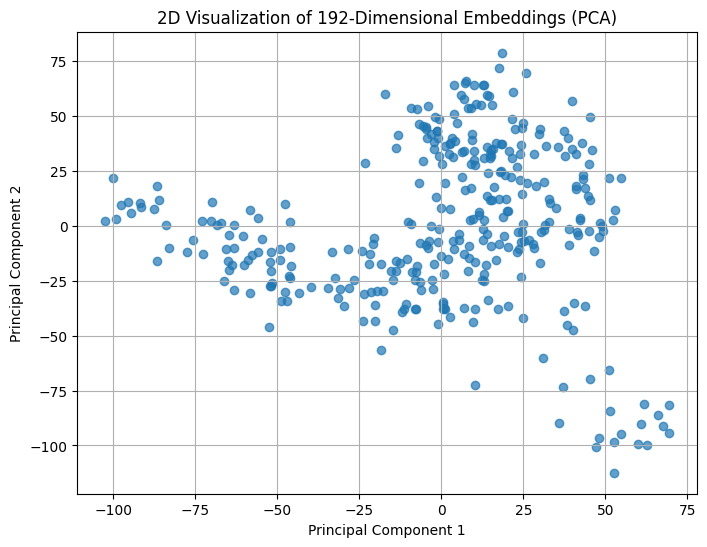

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# List all .npy files in the folder
npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
print(f"Found {len(npy_files)} .npy files.")

# Load all embeddings into a list and then stack them into an array
embeddings = []
for file in npy_files:
    emb = np.load(file)
    # If the file has an extra singleton dimension at axis 1, remove it.
    if emb.ndim == 3 and emb.shape[1] == 1:
        emb = np.squeeze(emb, axis=1)
    embeddings.append(emb)

# Now, embeddings is a list of arrays with shape (343, 192).
# Depending on what you need for PCA, you might want to stack or concatenate differently.
# For example, if you want to treat each of the 343 rows as a separate sample, you could do:
embeddings = np.vstack(embeddings)  # Shape: (n_files*343, 192)
print("Embeddings shape:", embeddings.shape)

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)
print("2D embeddings shape:", embeddings_2d.shape)

# Plot the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Visualization of 192-Dimensional Embeddings (PCA)")
plt.grid(True)
plt.show()


Found 343 .npy files.
Embeddings shape: (343, 192)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2D embeddings shape: (343, 2)


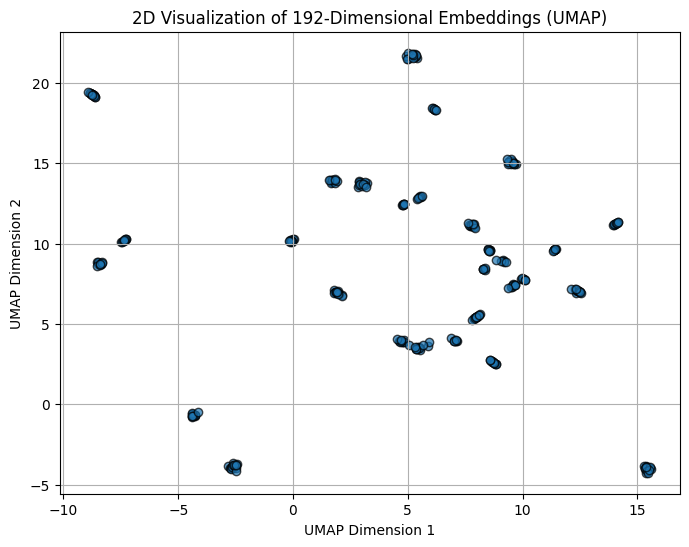

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap  # umap-learn

# List all .npy files in the folder
npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
print(f"Found {len(npy_files)} .npy files.")

# Load all embeddings into a list and then stack them into an array
embeddings = []
for file in npy_files:
    emb = np.load(file)
    # If the file has an extra singleton dimension at axis 1, remove it.
    if emb.ndim == 3 and emb.shape[1] == 1:
        emb = np.squeeze(emb, axis=1)
    embeddings.append(emb)

# Instead of np.array(embeddings), use np.vstack to create a 2D array.
# This will stack all rows from each file together.
embeddings = np.vstack(embeddings)  # Final shape: (n_files * 343, 192)
print("Embeddings shape:", embeddings.shape)

# Reduce the embeddings to 2 dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)
print("2D embeddings shape:", embeddings_2d.shape)

# Plot the UMAP projection
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("2D Visualization of 192-Dimensional Embeddings (UMAP)")
plt.grid(True)
plt.show()


explaination

Below is a **basic heuristic** for deciding whether PCA might be “good enough” or if a **non-linear** technique like t-SNE might be more appropriate. The script:

1. **Runs PCA** on your data and checks how many components are needed to reach a certain variance threshold (e.g., 80%).  
2. **Clusters** the PCA-transformed data and computes a silhouette score.  
3. **Runs t-SNE** and clusters again, computing a silhouette score in 2D.  
4. **Compares** the two scores (or the number of PCA components needed).

> **Disclaimer**: This is only a heuristic. In reality, you might try multiple thresholds, or compare additional metrics or clusterings (e.g., DBSCAN). t-SNE is also stochastic and may need repeated runs.

### How This Works

1. **PCA Full**  
   We fit PCA on the entire dataset to see how the variance is distributed across components. We then find how many components are required to reach, say, **80%** variance. That number (`n_comps`) indicates whether the data is mostly linear in a low-dimensional subspace.

2. **Cluster & Silhouette (PCA)**  
   We do KMeans on the first `n_comps` principal components. Then we compute the silhouette score, a measure of how well-separated the clusters are.

3. **t-SNE**  
   We reduce the data to 2D using t-SNE (a non-linear approach). Then we run KMeans in that 2D space and compute a silhouette score.

4. **Compare & Recommend**  
   We compare the silhouette scores and the number of PCA components needed. If a small number of components captures enough variance **and** yields a good silhouette, PCA is likely sufficient. If t-SNE yields a significantly higher silhouette, or if you need many PCA components, t-SNE might be more appropriate.

### Caveats

- **Silhouette Score vs. Domain Knowledge**  
  The silhouette score is only one metric. Also consider domain-specific constraints, e.g. speed, interpretability, or whether local structure is crucial.

- **t-SNE’s Stochasticity**  
  t-SNE has randomness. For stable results, you might want to run it multiple times with different seeds and average the scores.

- **Runtime**  
  t-SNE can be slow for large datasets. You might use **UMAP** (also non-linear) as a faster alternative, or sub-sample your data.

**In short,** this snippet provides a practical approach to help you decide whether your data’s structure is well-represented linearly (PCA) or if a non-linear manifold technique (like t-SNE) might be better.

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap  # Import UMAP from umap-learn

def choose_pca_or_umap(X, n_clusters=5, var_threshold=0.80):
    """
    Heuristic approach to decide whether to use PCA or UMAP for dimensionality reduction.
    
    1) Computes PCA on X and determines how many principal components are needed to explain 
       a specified fraction (var_threshold) of the variance.
    2) Clusters in the PCA subspace using KMeans and computes the silhouette score.
    3) Uses UMAP to reduce X to 2D, clusters in that space, and computes the silhouette score.
    4) Returns a recommendation based on the silhouette scores and the number of PCA components needed.
    
    :param X: Input data array of shape (n_samples, n_features).
    :param n_clusters: Number of clusters for KMeans.
    :param var_threshold: Fraction of variance to capture with PCA.
    :return: Tuple (recommendation string, sil_PCA, sil_UMAP).
    """
    
    # --- Step 1: PCA and variance check ---
    pca_full = PCA()
    X_pca_full = pca_full.fit_transform(X)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Number of components needed to reach var_threshold (e.g., 80% variance)
    n_comps = np.searchsorted(cumulative_variance, var_threshold) + 1
    print(f"[INFO] # PCA components needed to reach {var_threshold*100}% variance: {n_comps}")
    
    # Use only those components
    X_pca_sub = X_pca_full[:, :n_comps]
    
    # --- Step 2: Cluster in PCA subspace and compute silhouette score ---
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pca = kmeans_pca.fit_predict(X_pca_sub)
    sil_pca = silhouette_score(X_pca_sub, labels_pca)
    print(f"[INFO] Silhouette Score (PCA, {n_comps} comps): {sil_pca:.4f}")
    
    # --- Step 3: UMAP to 2D ---
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_umap_2d = umap_model.fit_transform(X)
    
    # Cluster in the UMAP space
    kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42)
    labels_umap = kmeans_umap.fit_predict(X_umap_2d)
    sil_umap = silhouette_score(X_umap_2d, labels_umap)
    print(f"[INFO] Silhouette Score (UMAP 2D): {sil_umap:.4f}")
    
    # --- Step 4: Heuristic recommendation ---
    if sil_pca > sil_umap + 0.02:
        recommendation = f"PCA is recommended. #Comps={n_comps}, sil(PCA)={sil_pca:.3f}, sil(UMAP)={sil_umap:.3f}"
    elif sil_umap > sil_pca + 0.02:
        recommendation = f"UMAP is recommended. #Comps={n_comps}, sil(PCA)={sil_pca:.3f}, sil(UMAP)={sil_umap:.3f}"
    else:
        # If the scores are close, if PCA requires many components, UMAP might be preferred
        if n_comps > 0.3 * X.shape[1]:
            recommendation = f"Scores close, but PCA requires many comps. UMAP might be better.\n  #Comps={n_comps}, sil(PCA)={sil_pca:.3f}, sil(UMAP)={sil_umap:.3f}"
        else:
            recommendation = f"Scores are close. PCA is simpler.\n  #Comps={n_comps}, sil(PCA)={sil_pca:.3f}, sil(UMAP)={sil_umap:.3f}"
    
    return recommendation, sil_pca, sil_umap

In [62]:
# Get list of all .npy files in the folder
npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
print(f"Found {len(npy_files)} .npy files in the enroll folder.")
embeddings = []
for file in npy_files:
    emb = np.load(file)
    # If the file has an extra singleton dimension at axis 1, remove it.
    if emb.ndim == 3 and emb.shape[1] == 1:
        emb = np.squeeze(emb, axis=1)
    embeddings.append(emb)

# Instead of np.array(embeddings), use np.vstack to create a 2D array.
# This will stack all rows from each file together.
embeddings = np.vstack(embeddings)  # Final shape: (n_files * 343, 192)

# Convert list to NumPy array of shape (n_samples, 192)
X_embeddings = np.array(embeddings)
print("Embeddings shape:", X_embeddings.shape)

Found 343 .npy files in the enroll folder.
Embeddings shape: (343, 192)


In [63]:
# np.random.seed(42)
# X_embeddings = np.random.randn(343, 192)  # e.g., 343 samples, each 192-dimensional

recommendation, sil_pca, sil_umap = choose_pca_or_umap(X_embeddings, n_clusters=5, var_threshold=0.80)
print("[FINAL RECOMMENDATION]", recommendation)

[INFO] # PCA components needed to reach 80.0% variance: 30
[INFO] Silhouette Score (PCA, 30 comps): 0.1154


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[INFO] Silhouette Score (UMAP 2D): 0.4492
[FINAL RECOMMENDATION] UMAP is recommended. #Comps=30, sil(PCA)=0.115, sil(UMAP)=0.449


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


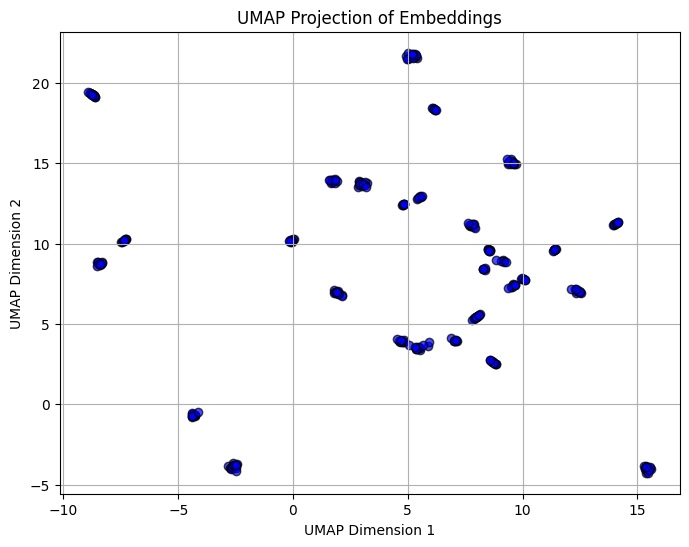

In [64]:
# Optionally, visualize the UMAP projection:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_model.fit_transform(X_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Projection of Embeddings")
plt.grid(True)
plt.show()

In [65]:
# dont understand above but ok 

Cluster labels: [11 11 11 11 11 11 11 11 11 11 27 27 27 27 27 27 27 27 27 27 27 25 25 25
 25 25 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 21 21 21 21 21 21 21 21 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 18 18 18 18 18 18
 18  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  4  4  4  4  4
  4  4  4  4  4  4  4 16 16 16 16 16 16 16 16 16 16 16 16 16 24 24 24 24
 24 24 22 22 22 22 22 22 22 22 22  3  3  3  3  3  3  3  3  3  3  3  3 25
  3  3  3  3  3 23 23 23 23 23 23 23 14 14 14 14 14 14 14  5  5  5  5  5
  5  5  5  5 20 20 20 20 20 20 20 20 20 20 20 20 20 20 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 10 10 10 10 10 10 10 10 10 10 10 10  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8 26 26 26 26 26 26 26 26 12 12
 12 12 12 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  8 28 28 2

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


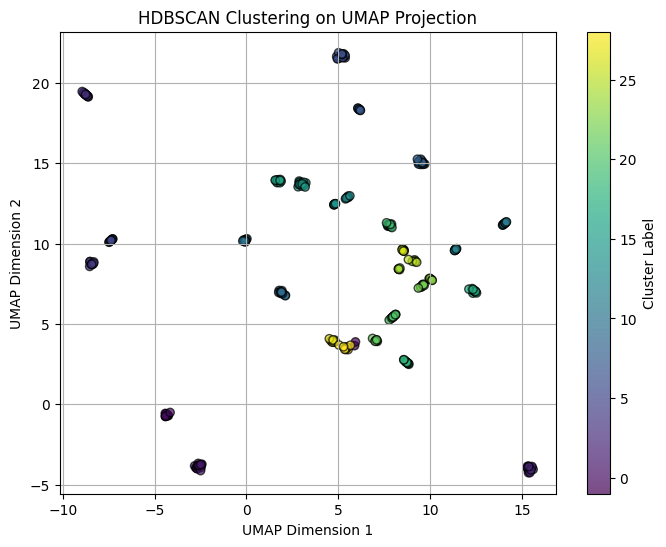

In [66]:
import hdbscan

# Train HDBSCAN on the UMAP 2D projection
# Adjust the parameters (min_cluster_size and min_samples) as needed.
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
cluster_labels = clusterer.fit_predict(X_umap_2d)

print("Cluster labels:", cluster_labels)
print("Number of clusters (excluding noise):", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))

# Visualize the clusters, coloring by the cluster label.
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("HDBSCAN Clustering on UMAP Projection")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()

## CHECK

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap  # from umap-learn
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, Counter

#############################
# 1. UMAP Reduction & KMeans Visualization on Enroll Data
#############################

# Assume enroll_folder_path is defined; it contains the enroll .npy files.
enroll_folder_path = 'dev_enroll_wav'

# List all enroll .npy files
enroll_files = [os.path.join(enroll_folder_path, f) for f in os.listdir(enroll_folder_path) if f.endswith('.npy')]
print(f"Found {len(enroll_files)} enroll files.")

# Load enroll embeddings and also record speaker IDs (assumed to be the first part of the file name, split by '-')
enroll_embeddings = []
enroll_speaker_ids = []  # will store strings like '500'
for file in enroll_files:
    emb = np.load(file)  # shape should be (192,)
    emb = np.squeeze(emb)
    enroll_embeddings.append(emb)
    # Extract speaker id from file name, e.g., "500-22000.npy"
    base = os.path.basename(file)
    speaker_id = base.split('-')[0]
    enroll_speaker_ids.append(speaker_id)
    
# Convert enroll embeddings to NumPy array of shape (n_samples, 192)
X_enroll = np.array(enroll_embeddings)
print("Enroll embeddings shape:", X_enroll.shape)

# Reduce enroll embeddings to 2D using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_model.fit_transform(X_enroll)

#############################
# 2. Cluster Enroll Embeddings with HDBSCAN & Determine Speaker’s Majority Cluster
#############################

# Run HDBSCAN on the UMAP 2D projection
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
hdbscan_labels = clusterer.fit_predict(X_umap_2d)
print("HDBSCAN labels:", hdbscan_labels)
num_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print(f"Number of HDBSCAN clusters (excluding noise): {num_clusters}")

# Group enroll samples by speaker using the file names.
# For each speaker, take the majority vote of the HDBSCAN labels.
speaker_cluster_mapping = {}  # mapping from speaker_id to majority cluster label

speaker_to_labels = defaultdict(list)
for speaker_id, label in zip(enroll_speaker_ids, hdbscan_labels):
    # We only consider non-noise labels, if desired. Otherwise, include all.
    if label != -1:
        speaker_to_labels[speaker_id].append(label)

# For each speaker, choose the majority cluster label
for speaker_id, labels in speaker_to_labels.items():
    if labels:  # if there are any valid labels
        majority_label = Counter(labels).most_common(1)[0][0]
        speaker_cluster_mapping[speaker_id] = majority_label

print("Speaker to Cluster Mapping (from enroll):")
for speaker, cluster in speaker_cluster_mapping.items():
    print(f"Speaker {speaker}: Cluster {cluster}")

#############################
# 3. Assign a Single Trial Utterance Embedding to a Cluster
#############################

# For demonstration, assume we have one trial .npy file:
trial_file = glob.glob(os.path.join(folder_paths['training_set']['voiceprint']['trial_path'], "*.npy"))[0]
print("Using trial file:", trial_file)

# Load and squeeze the trial embedding (shape should be (192,) after squeeze)
X_trial = np.squeeze(np.load(trial_file))
print("Trial embedding shape:", X_trial.shape)

# IMPORTANT: Use the same UMAP model fitted on enroll data to transform trial embedding.
# Note: X_trial must be 2D to transform; we reshape it accordingly.
X_trial_umap_2d = umap_model.transform(X_trial.reshape(1, -1))
print("Trial embedding UMAP projection shape:", X_trial_umap_2d.shape)

# Next, compute centroids for each enroll HDBSCAN cluster (in UMAP space).
cluster_points = defaultdict(list)
for point, label in zip(X_umap_2d, hdbscan_labels):
    if label != -1:
        cluster_points[label].append(point)
cluster_centroids = {label: np.mean(points, axis=0) for label, points in cluster_points.items()}

# Define a function to assign the trial utterance to the cluster with highest cosine similarity.
def assign_cluster(trial_point, centroids):
    trial_point = trial_point.reshape(1, -1)
    best_label = None
    best_sim = -1
    for label, centroid in centroids.items():
        centroid = centroid.reshape(1, -1)
        sim = cosine_similarity(trial_point, centroid)[0, 0]
        if sim > best_sim:
            best_sim = sim
            best_label = label
    return best_label

trial_assigned_cluster = assign_cluster(X_trial_umap_2d[0], cluster_centroids)
print("Assigned cluster for trial utterance:", trial_assigned_cluster)

#############################
# 4. Create New Feature: Match Between Speaker and Trial Utterance
#############################

# Extract speaker ID from the trial file name.
# Assuming the trial file name is formatted like "500-XXXX.npy" where "500" is the speaker id.
trial_basename = os.path.basename(trial_file)
trial_speaker_id = trial_basename.split("-")[0]
print("Trial speaker ID:", trial_speaker_id)

# Get the enrolled speaker's cluster (from enroll data)
enroll_cluster_for_speaker = speaker_cluster_mapping.get(trial_speaker_id, -1)
print("Enroll cluster for speaker", trial_speaker_id, ":", enroll_cluster_for_speaker)

# Create new feature: 1 if assigned cluster matches enroll cluster, else 0.
new_feature = 1 if trial_assigned_cluster == enroll_cluster_for_speaker else 0
print("New feature (1 if match, 0 if not):", new_feature)

Found 343 enroll files.
Enroll embeddings shape: (343, 192)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


HDBSCAN labels: [11 11 11 11 11 11 11 11 11 11 27 27 27 27 27 27 27 27 27 27 27 25 25 25
 25 25 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 21 21 21 21 21 21 21 21 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 18 18 18 18 18 18
 18  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  4  4  4  4  4
  4  4  4  4  4  4  4 16 16 16 16 16 16 16 16 16 16 16 16 16 24 24 24 24
 24 24 22 22 22 22 22 22 22 22 22  3  3  3  3  3  3  3  3  3  3  3  3 25
  3  3  3  3  3 23 23 23 23 23 23 23 14 14 14 14 14 14 14  5  5  5  5  5
  5  5  5  5 20 20 20 20 20 20 20 20 20 20 20 20 20 20 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 10 10 10 10 10 10 10 10 10 10 10 10  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8 26 26 26 26 26 26 26 26 12 12
 12 12 12 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  8 28 28 2

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


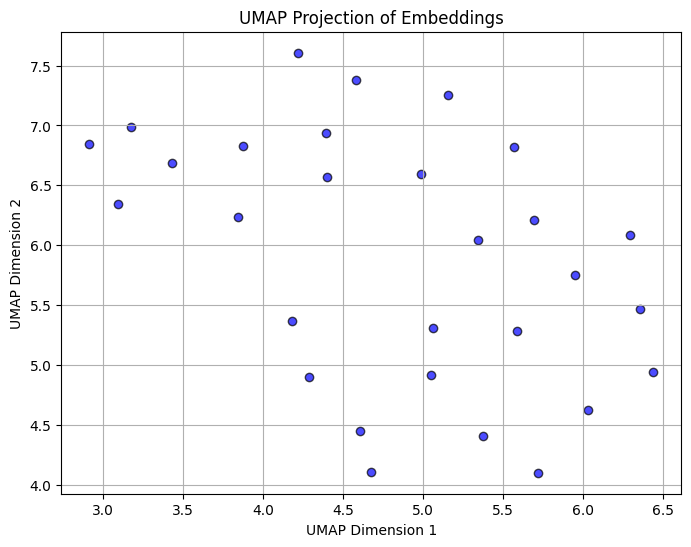

In [69]:
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Projection of Embeddings")
plt.grid(True)
plt.show()